In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import shap
import joblib






IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [3]:
# Set working directory to the notebook's directory
os.chdir(r"C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly")

# Now define your base directory relative to this location
base_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
db_name = os.path.join(base_dir, 'streetcardelaydb2.db')

print(f"Database path: {db_name}")

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data
table_name = 'Streetcar_Delay_Data'
df = load_from_db(db_name, table_name)


Database path: C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly\data\streetcardelaydb2.db


In [4]:
# Convert incident_date to datetime format
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get holidayType columns
date_table_name = 'Date'
conn = sqlite3.connect(db_name)
date_df = pd.read_sql_query(f'SELECT * FROM {date_table_name}', conn)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'holidayType']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)

# Load Season table to get seasonType column
season_table_name = 'Season'
season_df = pd.read_sql_query(f'SELECT * FROM {season_table_name}', conn)
season_df['date'] = pd.to_datetime(season_df['date'])

# Merge Season table with Streetcar_Delay_Data table on incident_date
df = df.merge(season_df[['date', 'season']], left_on='incident_date', right_on='date', how='left')
df.rename(columns={'season': 'seasonType'}, inplace=True)
df.drop(columns=['date'], inplace=True)

# Load Line table to get lineId and lineName (no lineType)
line_table_name = 'Line'
line_df = pd.read_sql_query(f'SELECT * FROM {line_table_name}', conn)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineName']], left_on='line', right_on='lineId', how='left')

# Load Delay table to get delayType
delay_table_name = 'Delay'
delay_df = pd.read_sql_query(f'SELECT * FROM {delay_table_name}', conn)

# Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Close the database connection
conn.close()

# Display the DataFrame
df.head()

,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,Winter 2023,510,Spadina,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,New Year's Day,Winter 2023,506,Carlton,2


In [5]:
# Display exploratory statistics
df.describe()

,incident_date,min_delay,min_gap,delayType
count,21742,21742.000000,21742.000000,21742.000000
mean,2023-11-17 14:32:47.730659584,18.185494,27.249885,2.133014
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-24 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-15 00:00:00,15.000000,24.000000,2.000000
max,2024-09-30 00:00:00,960.000000,968.000000,3.000000
std,NaN,37.272247,39.340414,0.561122


In [6]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  holidayType    502 non-null    object        
 11  seasonType     21742 non-null  object        
 12  lineId         21580 non-null  object        
 13  lineName       21580 non-null  object        
 14  delayType      21742 non-null  int64         
dtypes: datetime64[ns](1

*Comment:*

-The dataset `df` contains 21,742 entries. 

1. **Null Values**:
   - Several columns contain null values:
     - `line` has 44 null values.
     - `location` has 1 null value.
     - `bound` has a significant number of null values (2,615).
     - `holidayType` has many null values, with only 502 non-null entries.
     - `lineId` and `lineName` also have null values (162 each).

2. **Data Types**:
   - `incident_date` is in `datetime64[ns]` format.
   - Integer columns include `min_delay`, `min_gap`, and `delayType`.
   - The rest are stored as `object`, which includes categorical or string data, like `bound`, `day_of_week`, and `vehicle`.

3. **Column Names and Non-Null Counts**:
   - This output can help identify where data cleaning might be necessary, such as handling the null values in `bound` and `holidayType`.



*Note:* 

- When TTC streetcars are out of service and buses are used as substitutes, these buses are typically assigned the same route number as the streetcar line they are replacing. This helps passengers easily identify the substitute service and understand that it follows the same route as the regular streetcar service.

- For example, if a streetcar on route 509 Harbourfront is out of service, a bus might be assigned route number 509 to continue providing service along the same path.

- Therefore, we can drop the null values in 'line'.


In [7]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
holidayType         9
seasonType          8
lineId             17
lineName           12
delayType           3
dtype: int64

In [8]:
# Let's see why 'bound' has 8 unique values when it should only have 4 (N, S, W, E)
df['bound'].unique()


array(['W', 'E', 'S', None, 'N', 'B', '`', '1', '8'], dtype=object)

In [9]:
# Define the allowed values
allowed_bounds = ['N', 'S', 'W', 'E']

# Filter the DataFrame to keep only rows where 'bound' is in the allowed list
df = df[df['bound'].isin(allowed_bounds)]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
df['bound'].unique()


array(['W', 'E', 'S', 'N'], dtype=object)

In [10]:
# Drop rows with null values in any column except 'holidayType'
df = df.dropna(subset=[col for col in df.columns if col != 'holidayType'])

# Confirm the remaining rows and null counts
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 18985 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18985 non-null  datetime64[ns]
 1   line           18985 non-null  object        
 2   incident_time  18985 non-null  object        
 3   day_of_week    18985 non-null  object        
 4   location       18985 non-null  object        
 5   incident       18985 non-null  object        
 6   min_delay      18985 non-null  int64         
 7   min_gap        18985 non-null  int64         
 8   bound          18985 non-null  object        
 9   vehicle        18985 non-null  object        
 10  holidayType    436 non-null    object        
 11  seasonType     18985 non-null  object        
 12  lineId         18985 non-null  object        
 13  lineName       18985 non-null  object        
 14  delayType      18985 non-null  int64         
dtypes: datetime64[ns](1), in

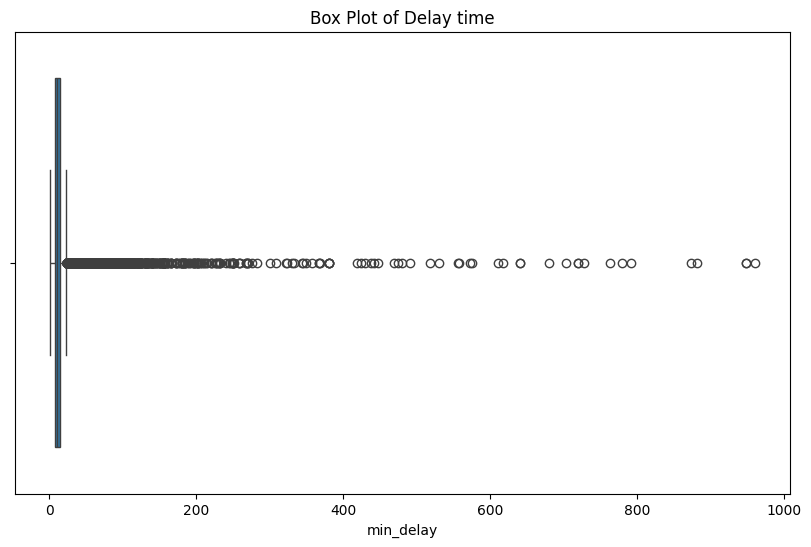

In [11]:
# Check for class imbalance with data visualization tools.

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

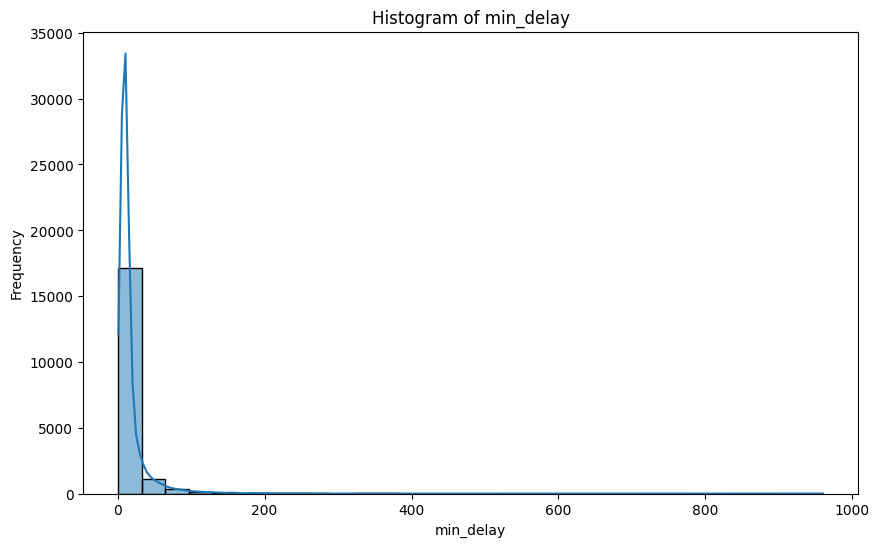

In [12]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

In [13]:
df['min_delay'].nlargest(20)


4744     960
4530     948
4550     948
4506     882
16055    873
15955    792
4761     780
170      763
4240     728
3018     720
3972     720
18556    703
15956    680
4421     641
13218    640
5351     618
15680    611
1020     575
5737     573
14167    558
Name: min_delay, dtype: int64

In [14]:
# Create a new DataFrame with min_delay values less than 60 minutes
df_new = df[df['min_delay'] < 61]

# Display the new DataFrame
df_new.head()



,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,Winter 2023,510,Spadina,2
4,2023-01-01,501,08:52,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,New Year's Day,Winter 2023,501,Queen,2


In [15]:
df_new.describe()

,incident_date,min_delay,min_gap,delayType
count,18234,18234.000000,18234.000000,18234.000000
mean,2023-11-18 08:59:18.538993152,12.878469,21.901338,2.086377
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-25 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-17 00:00:00,12.000000,21.000000,2.000000
max,2024-09-30 00:00:00,60.000000,224.000000,3.000000
std,NaN,9.842077,12.129825,0.540518


In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18234 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18234 non-null  datetime64[ns]
 1   line           18234 non-null  object        
 2   incident_time  18234 non-null  object        
 3   day_of_week    18234 non-null  object        
 4   location       18234 non-null  object        
 5   incident       18234 non-null  object        
 6   min_delay      18234 non-null  int64         
 7   min_gap        18234 non-null  int64         
 8   bound          18234 non-null  object        
 9   vehicle        18234 non-null  object        
 10  holidayType    425 non-null    object        
 11  seasonType     18234 non-null  object        
 12  lineId         18234 non-null  object        
 13  lineName       18234 non-null  object        
 14  delayType      18234 non-null  int64         
dtypes: datetime64[ns](1), in

In [17]:
# Ensure consistent parsing of datetime
df_new['incident_time'] = pd.to_datetime(
    df_new['incident_time'], 
    format='%H:%M',  # Adjust format based on time data (e.g., 'HH:MM')
    errors='coerce'
).dt.time

# Define function to categorize time
def categorize_time(time):
    if pd.isna(time):
        return None
    if pd.to_datetime('06:30').time() <= time <= pd.to_datetime('09:30').time():
        return 'morning_peak'
    elif pd.to_datetime('10:00').time() <= time <= pd.to_datetime('14:00').time():
        return 'midday'
    elif pd.to_datetime('16:30').time() <= time <= pd.to_datetime('19:00').time():
        return 'evening_peak'
    else:
        return 'off_peak'

# Apply function to create new column "timeType"
df_new = df_new.copy()  # Ensure df_new is independent
df_new['timeType'] = df_new['incident_time'].apply(categorize_time)

# Define a helper function for cleaning columns
def clean_column(df, column_name, valid_values=None):
    # Work on a copy of the DataFrame
    cleaned_df = df.copy()
    
    # Remove leading/trailing spaces
    cleaned_df.loc[:, column_name] = cleaned_df[column_name].str.strip()
    
    # Drop rows with null values in the specified column
    cleaned_df = cleaned_df[cleaned_df[column_name].notna()]
    
    # Filter rows by valid values if provided
    if valid_values:
        cleaned_df = cleaned_df[cleaned_df[column_name].isin(valid_values)]
    
    return cleaned_df

# Initialize df_cleaned as a copy of df_new
df_cleaned = df_new.copy()

# Clean columns
columns_to_clean = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound']
for col in columns_to_clean:
    df_cleaned = clean_column(df_cleaned, col)

# Recreate df_cleaned to ensure independence
df_cleaned = df_cleaned.copy()

# One-Hot Encode Categorical Columns
categorical_cols = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound', 'timeType', 'holidayType', 'seasonType']

# Use pandas get_dummies to one-hot encode the categorical columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
# Display the DataFrame after one-hot encoding
df_cleaned.head()


,incident_date,incident_time,min_delay,min_gap,lineId,lineName,delayType,location_1 DAVIES AVE,location_10 RITCHIE AVE,location_100 KING ST W,...,holidayType_New Year's Day,holidayType_Thanksgiving,holidayType_Victoria Day,seasonType_Fall 2024,seasonType_Spring 2023,seasonType_Spring 2024,seasonType_Summer 2023,seasonType_Summer 2024,seasonType_Winter 2023,seasonType_Winter 2024
0,2023-01-01,02:40:00,15,25,505,Dundas,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
1,2023-01-01,02:52:00,10,20,504,King,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,2023-01-01,02:59:00,25,35,504,King,3,False,False,False,...,True,False,False,False,False,False,False,False,True,False
3,2023-01-01,05:38:00,15,30,510,Spadina,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,2023-01-01,08:52:00,10,20,501,Queen,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [19]:
print(df_cleaned.dtypes)  # This should show only numeric data types



incident_date             datetime64[ns]
incident_time                     object
min_delay                          int64
min_gap                            int64
lineId                            object
                               ...      
seasonType_Spring 2024              bool
seasonType_Summer 2023              bool
seasonType_Summer 2024              bool
seasonType_Winter 2023              bool
seasonType_Winter 2024              bool
Length: 4400, dtype: object


In [20]:
# Save column data types to a text file
with open("data_types_output.txt", "w") as file:
    file.write(df_cleaned.dtypes.to_string())


In [21]:
df_cleaned.describe()

,incident_date,min_delay,min_gap,delayType
count,18234,18234.000000,18234.000000,18234.000000
mean,2023-11-18 08:59:18.538993152,12.878469,21.901338,2.086377
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-25 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-17 00:00:00,12.000000,21.000000,2.000000
max,2024-09-30 00:00:00,60.000000,224.000000,3.000000
std,NaN,9.842077,12.129825,0.540518


In [22]:
# Drop the following columns: incident_date, incident_time, min_gap, lineID. lineName
df_cleaned = df_cleaned.drop(['incident_date','incident_time', 'min_gap', 'lineId', 'lineName'], axis=1)


In [23]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12771
3     3519
1     1944
Name: count, dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



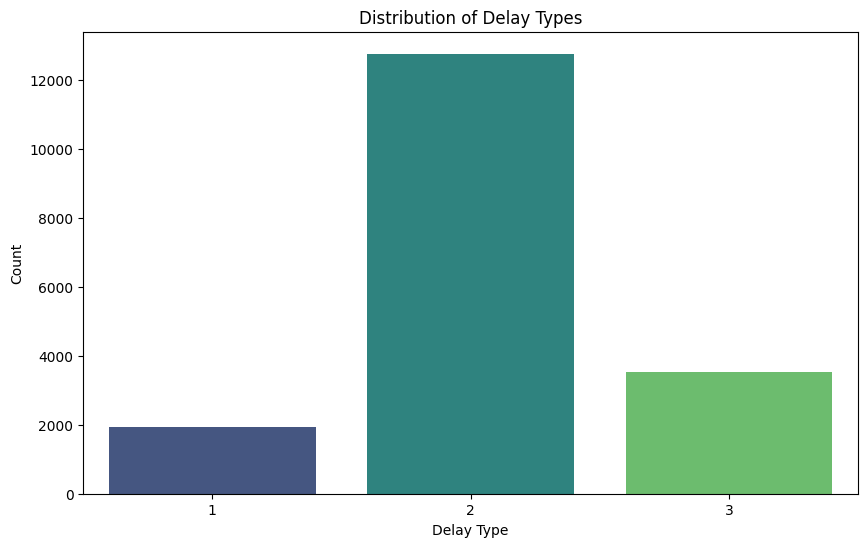

In [24]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


In [25]:
# Define X and y: 
X = df_cleaned.drop(columns=['min_delay', 'delayType']) 
y = df_cleaned['delayType']

In [26]:
# Save column data types to a text file
with open("X_data_types_output.txt", "w") as file:
    file.write(X.dtypes.to_string())

In [27]:

# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Convert y_train to integer if it’s categorical
y_train = y_train.astype(int)

In [ ]:
# Set up stratified cross-validation on the training set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tune max_depth on the training set using stratified cross-validation
max_depth_range = range(1, 26)
balanced_accuracy_depth = []

for max_depth in max_depth_range:
    rf_temp = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
    mean_score = scores.mean()
    balanced_accuracy_depth.append(mean_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, balanced_accuracy_depth, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Note:*

1. **`class_weight='balanced'`**: This adjustment helps the model **learn better from the minority classes** by applying a higher weight to underrepresented classes during training. This step ensures that the model does not ignore these classes simply because they are less frequent.

2. **`balanced_accuracy` as a Scoring Metric**: Even with `class_weight='balanced'`, using `balanced_accuracy` for evaluation remains useful. Provide an **evaluation metric that reflects balanced performance** across the delayTypes, preventing the model from being overly influenced by the majority class.  

*Interpretation:*

- Optimal max-depth value is about 20 trees. 

In [ ]:
# Tune both max_depth and n_estimators on the training set using stratified cross-validation
max_depth_range = [18, 20, 22]  # Limited max_depth range for faster tuning
n_estimators_range = range(5, 210, 10)  # Range for n_estimators
results = []  # To store results for each combination

for max_depth in max_depth_range:
    balanced_accuracy_scores = []
    for n_estimators in n_estimators_range:
        rf_temp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        # Perform cross-validation with balanced accuracy scoring
        scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
        mean_score = scores.mean()
        balanced_accuracy_scores.append(mean_score)
    
    # Store results for this max_depth
    results.append((max_depth, balanced_accuracy_scores))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores in results:
    plt.plot(n_estimators_range, scores, label=f"Max Depth: {max_depth}", marker='o')

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*
= The optimal number of 'n' is about 75-100 trees, and optimal max-depth value of 20. 

In [ ]:
# Define the parameter grid with max_depth fixed at 20
param_grid = {
    'n_estimators': [75, 85, 100],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


# Initialize the Random Forest Classifier with fixed max_depth
clf = RandomForestClassifier(max_depth=20, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


In [28]:
best_params = {
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'n_estimators': 85,  # Number of trees in the forest
     'max_depth': 20  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=85,
                       random_state=42)

In [29]:
y_pred = best_clf.predict(X_test)



In [30]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
2823                 incident_Diversion    0.093264
4371                           line_512    0.076124
2829                incident_Mechanical    0.051701
4377                  timeType_off_peak    0.030017
2822  incident_Collision - TTC Involved    0.026492
...                                 ...         ...
2104    location_QUEEN ST W AND BATHURS    0.000000
2105    location_QUEEN ST W AND BEATY A    0.000000
2106    location_QUEEN ST W AND BROCK A    0.000000
2107    location_QUEEN ST W AND DUFFERI    0.000000
0                 location_1 DAVIES AVE    0.000000

[4393 rows x 2 columns]


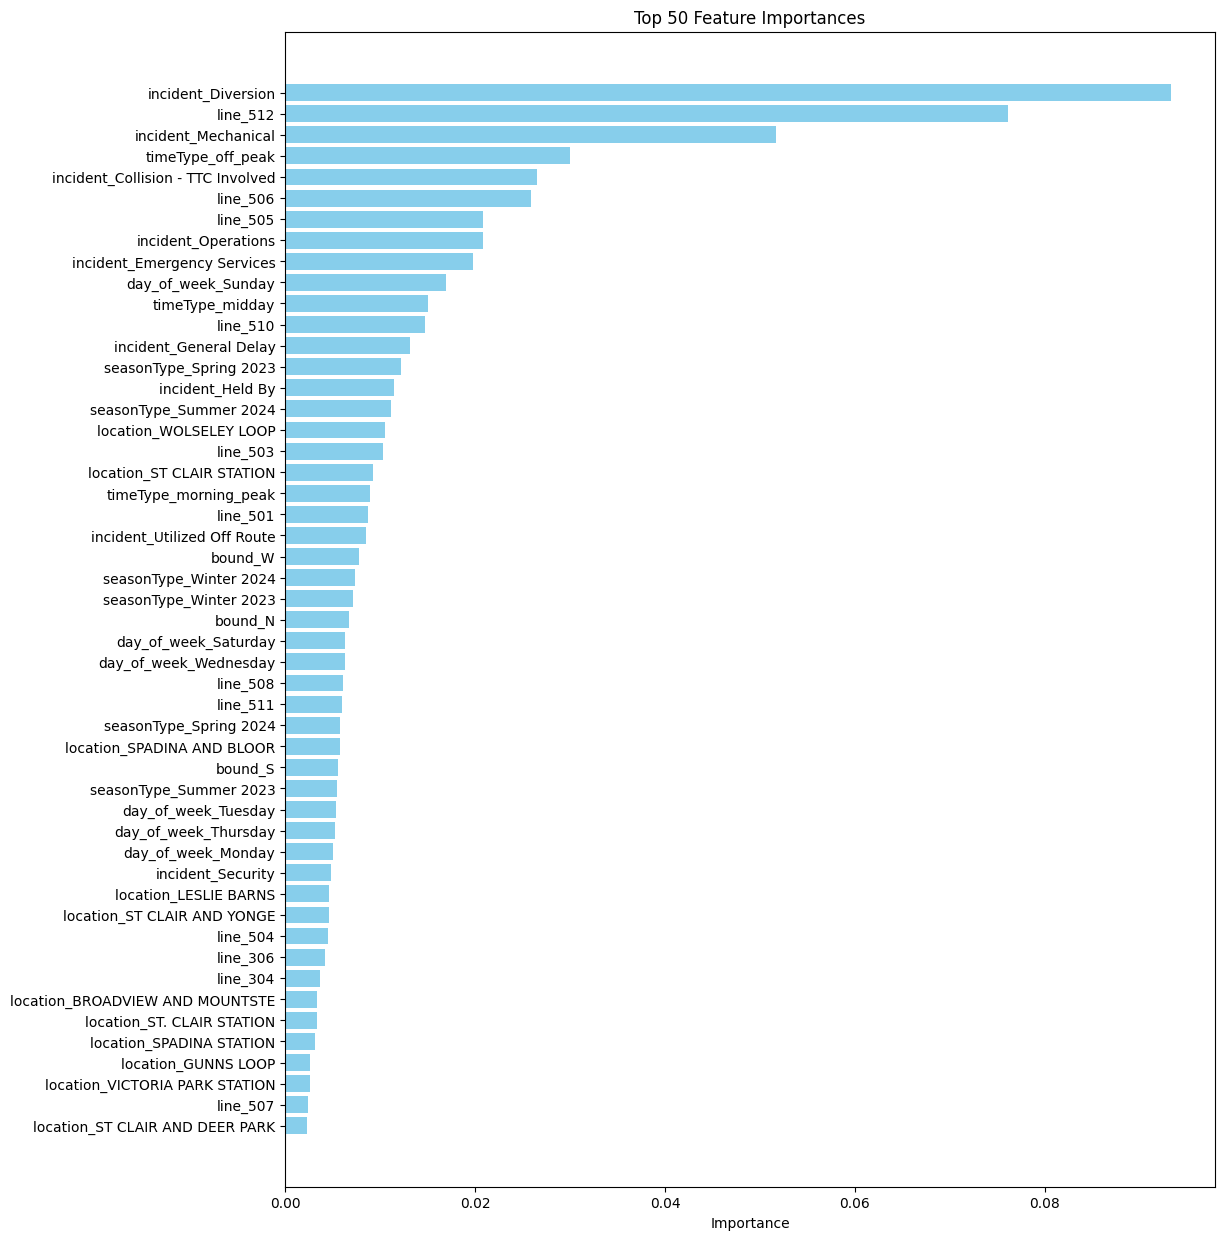

In [31]:
# Select the top features
top_features = importance_df.head(50)

# Plot the top 200 feature importances
plt.figure(figsize=(12, 15))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [32]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.34      0.59      0.44       583
           2       0.82      0.59      0.69      3832
           3       0.37      0.60      0.46      1056

    accuracy                           0.59      5471
   macro avg       0.51      0.59      0.53      5471
weighted avg       0.68      0.59      0.61      5471


Balanced Accuracy: 0.59


In [33]:
# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)


In [34]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]


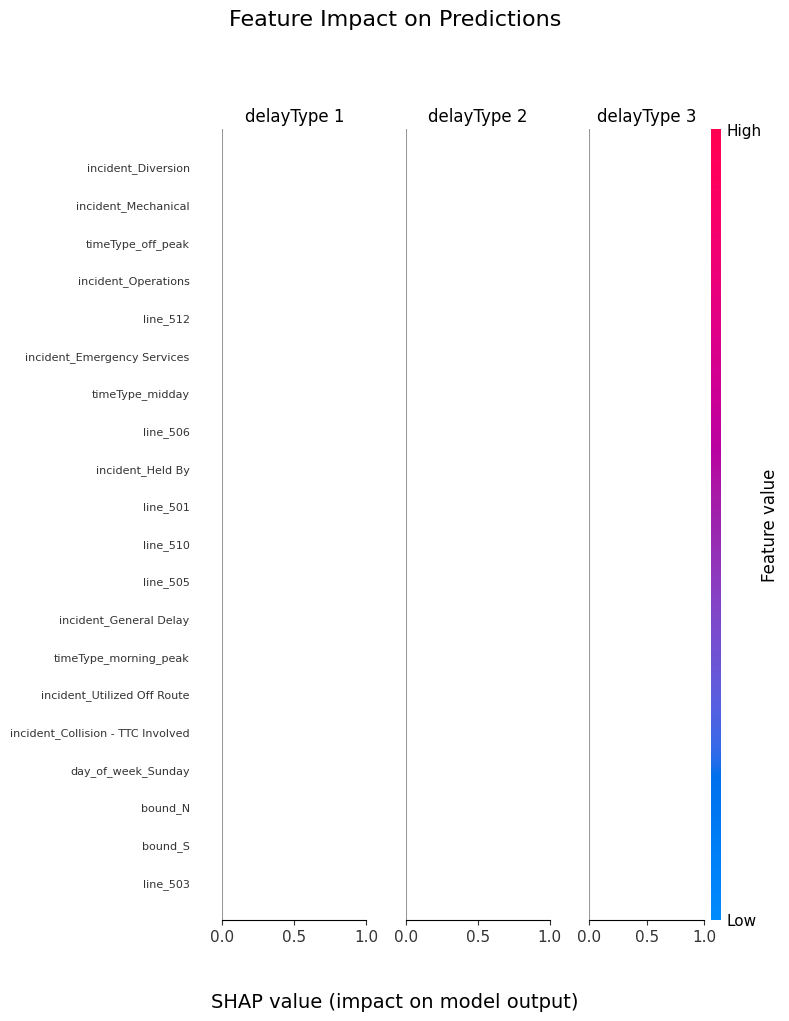

In [35]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)  # 1 row, 3 columns

# Beeswarm plot for delayType = 1
plt.sca(axes[0])  # Set the current axis to the first subplot
shap.summary_plot(shap_values_class1, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[0].set_title("delayType 1", fontsize=12)
axes[0].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[0].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 2
plt.sca(axes[1])  # Set the current axis to the second subplot
shap.summary_plot(shap_values_class2, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[1].set_title("delayType 2", fontsize=12)
axes[1].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[1].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 3
plt.sca(axes[2])  # Set the current axis to the third subplot
shap.summary_plot(shap_values_class3, X_test, plot_type="beeswarm", show=False)  # Keep color bar
axes[2].set_title("delayType 3", fontsize=12)
axes[2].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[2].set_xlabel("")  # Remove X-axis label

# Add a centered title above all subplots
fig.suptitle("Feature Impact on Predictions", fontsize=16, y=1)  # Adjust y for better spacing

# Add a single label below the x-axes
fig.text(0.5, -0.05, "SHAP value (impact on model output)", ha='center', fontsize=14)

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for the suptitle
plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


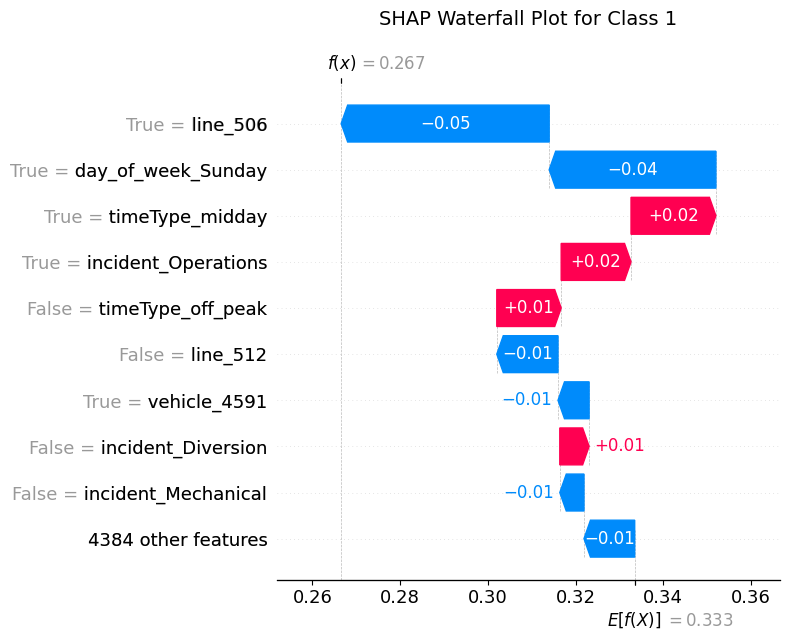

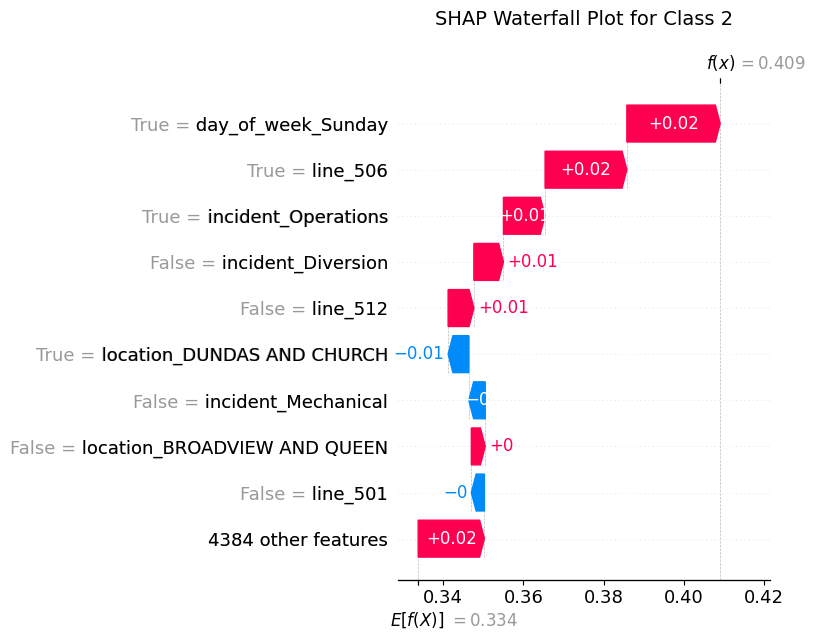

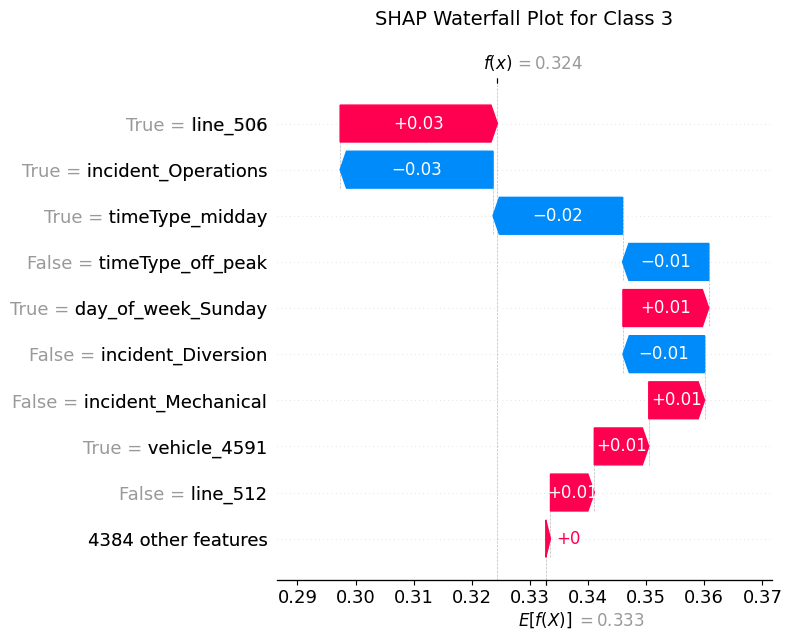

In [36]:
# Sample index for demonstration
sample_index = 0

# Store shap values for the 3 classes in a list of arrays
shap_values_list = [shap_values_class1, shap_values_class2, shap_values_class3]

# Iterate through each class to create waterfall plots
for i in range(len(shap_values_list)):
    shap_values_class = shap_values_list[i]
    
    # Create SHAP explanation object for the current class
    explanation = shap.Explanation(
        values=shap_values_class[sample_index],
        base_values=explainer.expected_value[i],  # Base value for the current class
        data=X_test.iloc[sample_index],
        feature_names=X_test.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Optional: Set figure size
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for Class {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Ensure layout fits well
    plt.show()  # Display the plot


REMOVE OVER 4,000 FEATURES TO ONLY KEEP 20 TOP FEATURES FOR X, AND RE-FIT MODEL.

In [37]:
# Select the top features
top_features = importance_df.head(50)


In [38]:
# Save the top 50 features as a CSV file
csv_file_path = "top_50_features.csv"  # Define your file name and path
top_features.to_csv(csv_file_path, index=False)  # Save the top 50 features without the index column
print(f"Top 50 features saved to {csv_file_path}")



Top 50 features saved to top_50_features.csv


In [23]:
# `top_features` is a list of the top feature names
top_features_list = top_features['Feature'].tolist()

# Redefine X to include only the top features
X = df_cleaned[top_features_list]
y = df_cleaned['delayType']  # Target variable

# Step 1: Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:

# Set up stratified cross-validation on the training set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tune max_depth on the training set using stratified cross-validation
max_depth_range = range(1, 26)
balanced_accuracy_depth = []

for max_depth in max_depth_range:
    rf_temp = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
    mean_score = scores.mean()
    balanced_accuracy_depth.append(mean_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, balanced_accuracy_depth, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:* 
- Optimal Max Depth is between 6 and 9.

In [ ]:
# Tune both max_depth and n_estimators on the training set using stratified cross-validation
max_depth_range = [6,7,8,9]  # Limited max_depth range for faster tuning
n_estimators_range = range(5, 210, 10)  # Range for n_estimators
results = []  # To store results for each combination

for max_depth in max_depth_range:
    balanced_accuracy_scores = []
    for n_estimators in n_estimators_range:
        rf_temp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        # Perform cross-validation with balanced accuracy scoring
        scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
        mean_score = scores.mean()
        balanced_accuracy_scores.append(mean_score)
    
    # Store results for this max_depth
    results.append((max_depth, balanced_accuracy_scores))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores in results:
    plt.plot(n_estimators_range, scores, label=f"Max Depth: {max_depth}", marker='o')

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*
- Optimal max-depth is 8. 
- Optimal number of trees is about between 50 and 75.

In [ ]:

# Define the parameter grid with max_depth fixed at 18
param_grid = {
    'n_estimators': [50, 55, 60, 65, 70, 75],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


# Initialize the Random Forest Classifier with fixed max_depth
clf = RandomForestClassifier(max_depth=8, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


In [24]:

best_params = {
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 10,  # Minimum number of samples required to split an internal node
    'n_estimators': 50,  # Number of trees in the forest
     'max_depth': 8  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=10, n_estimators=50, random_state=42)

In [25]:
y_pred = best_clf.predict(X_test)

In [26]:

# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                              Feature  Importance
0                  incident_Diversion    0.257973
1                            line_512    0.161833
2                 incident_Mechanical    0.069406
5                            line_506    0.058014
3                   timeType_off_peak    0.057802
15             seasonType_Summer 2024    0.046666
6                            line_505    0.041876
13             seasonType_Spring 2023    0.037577
8         incident_Emergency Services    0.036584
9                  day_of_week_Sunday    0.035261
4   incident_Collision - TTC Involved    0.030351
11                           line_510    0.029016
12             incident_General Delay    0.028165
7                 incident_Operations    0.023299
14                   incident_Held By    0.020700
17                           line_503    0.017095
10                    timeType_midday    0.014865
16             location_WOLSELEY LOOP    0.012900
18          location_ST CLAIR STATION    0.010460


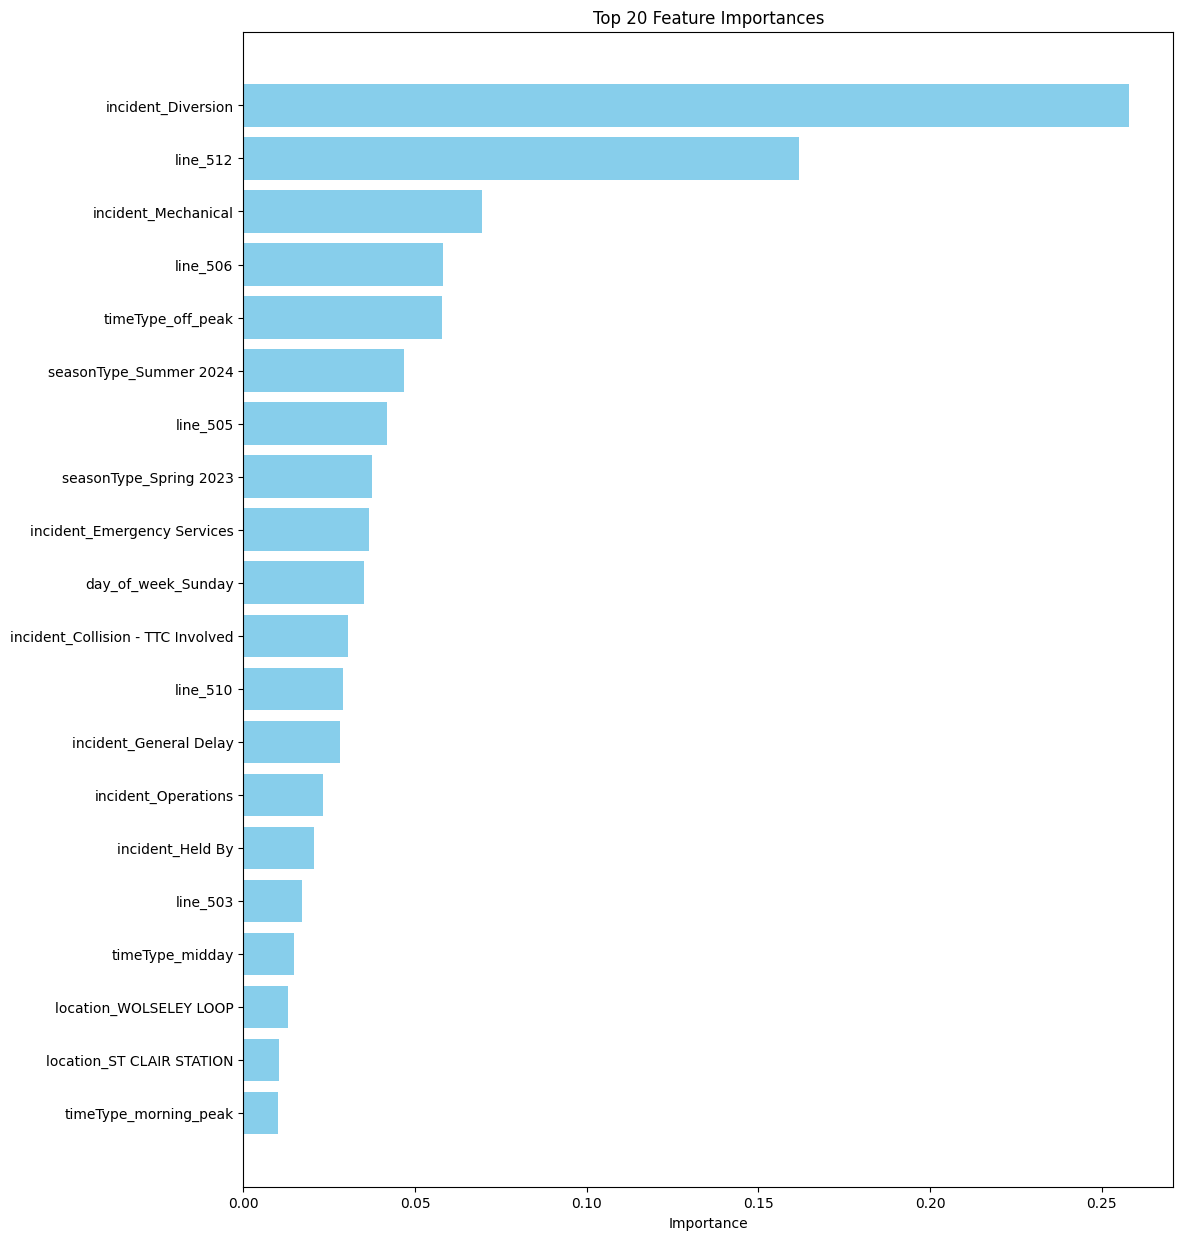

In [27]:
# Plot the top feature importances
plt.figure(figsize=(12, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [28]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.27      0.64      0.38       583
           2       0.82      0.57      0.67      3832
           3       0.41      0.54      0.47      1056

    accuracy                           0.57      5471
   macro avg       0.50      0.58      0.50      5471
weighted avg       0.68      0.57      0.60      5471


Balanced Accuracy: 0.58


*Observation:*
- The new model with 20 features produces slightly poorer than the original model with over 4,300 features, but runs faster. 

In [29]:
# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)

In [30]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]

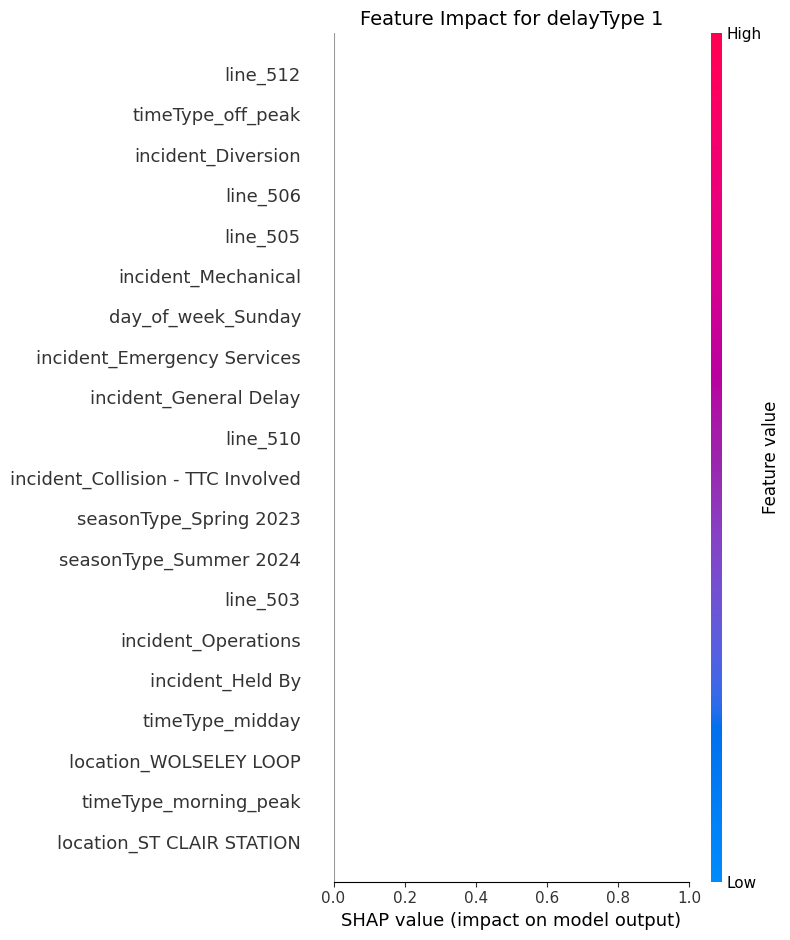

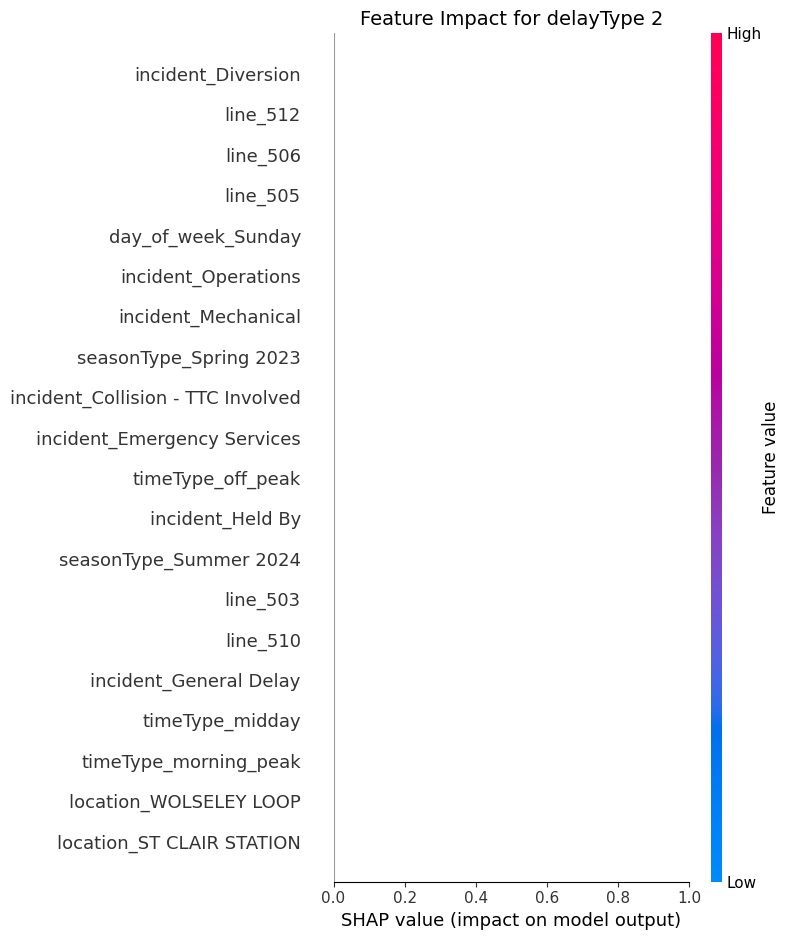

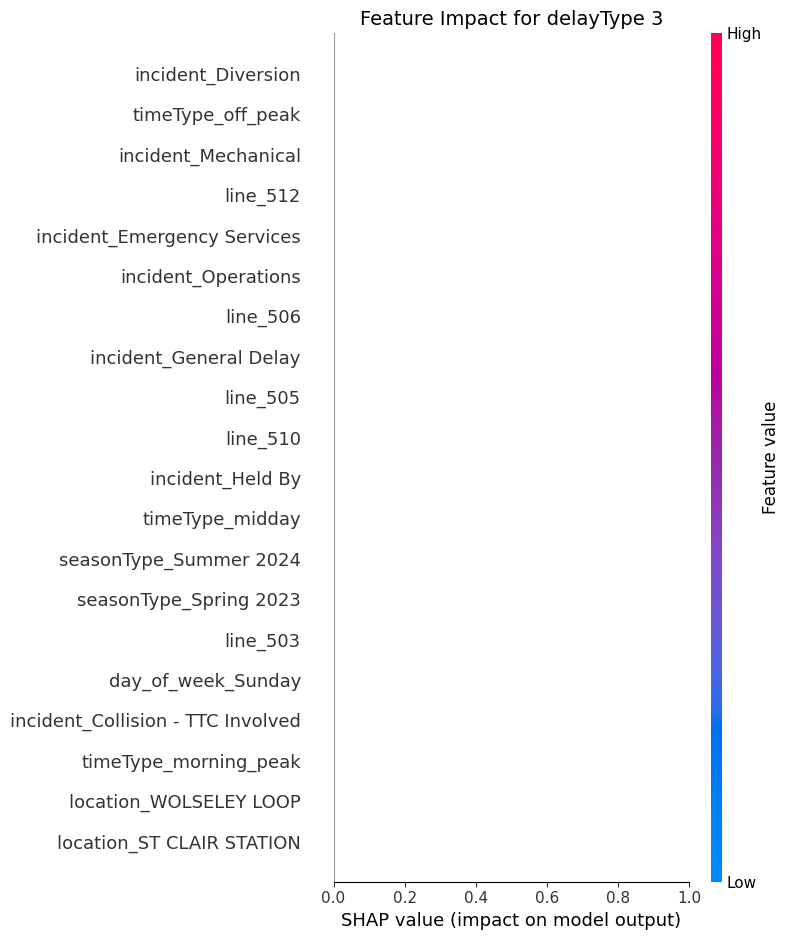

In [31]:
# Close all previous figures
plt.close('all')

# Beeswarm plot for delayType = 1
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_class1, 
    X_test, 
    plot_type="beeswarm", 
    show=False, 
    )

plt.gca().set_title("Feature Impact for delayType 1", fontsize=14)  # Set the title directly in the SHAP plot's axis
plt.tight_layout()
plt.show()


# Beeswarm plot for delayType = 2
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_class2, 
    X_test, 
    plot_type="beeswarm", 
    show=False, 
    )

plt.gca().set_title("Feature Impact for delayType 2", fontsize=14)  # Set the title directly in the SHAP plot's axis
plt.tight_layout()
plt.show()


# Beeswarm plot for delayType = 3
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_class3, 
    X_test, 
    plot_type="beeswarm", 
    show=False
)
plt.gca().set_title("Feature Impact for delayType 3", fontsize=14)  # Set the title directly in the SHAP plot's axis
plt.tight_layout()
plt.show()




findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


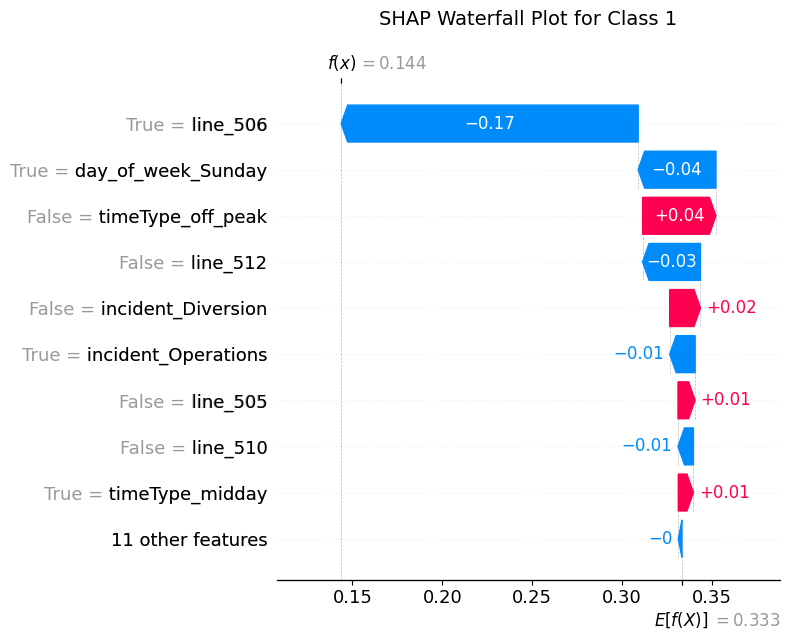

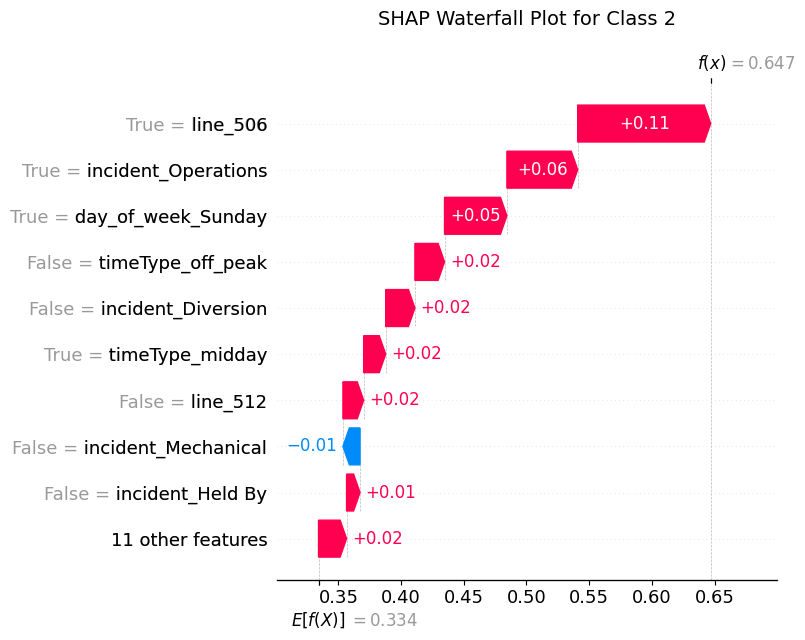

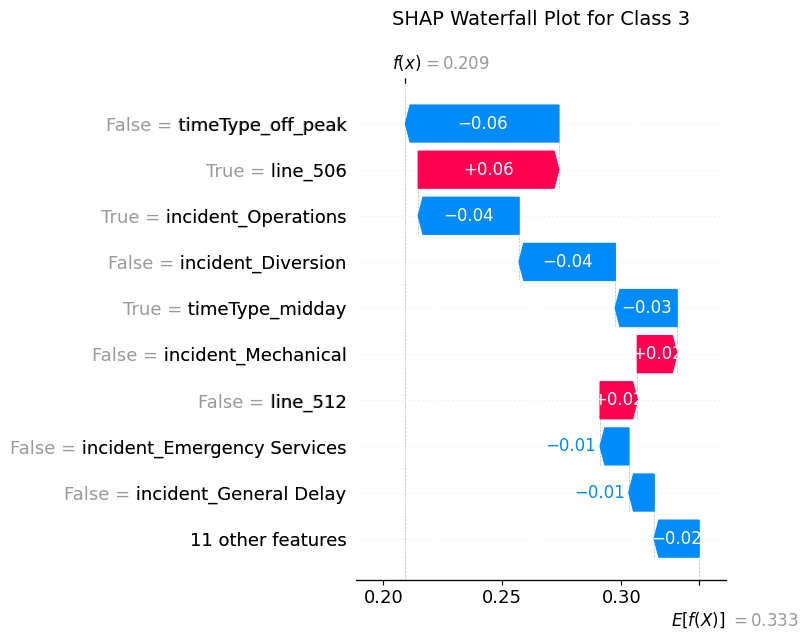

In [32]:
# Sample index for demonstration
sample_index = 0

# Assuming you have the SHAP values for each class in separate arrays
# For demonstration purposes, let's say they are stored in a list of arrays
shap_values_list = [shap_values_class1, shap_values_class2, shap_values_class3]

# Iterate through each class to create waterfall plots
for i in range(len(shap_values_list)):
    shap_values_class = shap_values_list[i]
    
    # Create SHAP explanation object for the current class
    explanation = shap.Explanation(
        values=shap_values_class[sample_index],
        base_values=explainer.expected_value[i],  # Base value for the current class
        data=X_test.iloc[sample_index],
        feature_names=X_test.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Optional: Set figure size
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for Class {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Ensure layout fits well
    plt.show()  # Display the plot

In [41]:
# Save the trained model to a file
model_file_path = "delay_type_predictor.pkl"
joblib.dump(best_clf, model_file_path)
print(f"Trained model saved to {model_file_path}")



Trained model saved to delay_type_predictor.pkl
